#프로젝트 기획 목표

음식 사진으로 어떤 음식인지 구분해내는 모델을 개발 하는 것을 목표로 함

#프로젝트 내용

* Dataset은 Google 에서 직접 수집한 20종류, 2921장의 음식 이미지(jpg포맷)이다.

* 훈련 데이터와 검증 데이터로 구분하여 분류

* Data augmentation 수행

* CNN 모델 설계

* Optimizer는 Adam을 이용했고, learning rate는 adam의 기본값인 0.001, loss_function = categorical_crossentropy로 학습 진행

* checkpoint를 사용하여 training과 test에서 최적의 accuracy를 보이는 모델을 고르고자 함

* 콜백 함수로 ReduceLROnPlateau를 이용

* matplotlib을 통한 accuracy와 loss 확인

#모델 개선

* batch size가 32일 때 보다 16일 때 결과가 더 좋음.
* Drop out 레이어를 사용했을 때 결과가 더 좋음.
* 데이터 부족으로 train-test set 비율을 8:2에서 9:1로 바꿈
* Optimizer을 Adam 에서 RMSprop으로 바꾸었을 때 정확도 소폭 상승

In [1]:
# 구글 드라이브 마운트

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [82]:
# import

import os
import PIL
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [ ]:
cd /content/drive/MyDrive/ML_Dataset

/content/drive/MyDrive/ML_Dataset


In [ ]:
!unzip -qq "/content/drive/MyDrive/data_plus.zip"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
족발/Img_131_0501.jpg:  mismatching "local" filename (ьб▒ы░Ь/Img_131_0501.jpg),
         continuing with "central" filename version
족발/Img_131_0502.jpg:  mismatching "local" filename (ьб▒ы░Ь/Img_131_0502.jpg),
         continuing with "central" filename version
족발/Img_131_0503.jpg:  mismatching "local" filename (ьб▒ы░Ь/Img_131_0503.jpg),
         continuing with "central" filename version
족발/Img_131_0504.jpg:  mismatching "local" filename (ьб▒ы░Ь/Img_131_0504.jpg),
         continuing with "central" filename version
족발/Img_131_0505.jpg:  mismatching "local" filename (ьб▒ы░Ь/Img_131_0505.jpg),
         continuing with "central" filename version
족발/Img_131_0506.jpg:  mismatching "local" filename (ьб▒ы░Ь/Img_131_0506.jpg),
         continuing with "central" filename version
족발/Img_131_0507.jpg:  mismatching "local" filename (ьб▒ы░Ь/Img_131_0507.jpg),
         continuing with "central" filename version
족발/Img_131_0508.jpg:  mismatching "local" filename (ьб

In [94]:
# batch, 이미지 크기 지정

batch_size = 32
img_height = 128
img_width = 128
# lr = 0.01

In [95]:
# 이미지 경로 지정

import pathlib

data_dir = pathlib.Path('/content/drive/MyDrive/ML_Dataset')

In [128]:
# train set 분리

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9998 files belonging to 10 classes.
Using 8999 files for training.


In [129]:
# test set 분리

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9998 files belonging to 10 classes.
Using 999 files for validation.


In [110]:
# class 확인

class_names = train_ds.class_names
print(class_names)

['갈비탕', '계란후라이', '김밥', '닭볶음탕', '떡볶이', '순대', '제육볶음', '족발', '찜닭', '피자']


In [130]:
# 실제 이미지와 정답 레이블의 shape 확인

for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 128, 128, 3)
(32,)


In [112]:
# 데이터 전처리 normalization

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [131]:
# 데이터셋 객체에 적용, 전처리 레이어 생성

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))

0.058287382 1.0


In [132]:
# 데이터 증강(augmentation) 레이어 생성 (오버피팅 완화)

data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)
# 1. 랜덤하게 좌우 변형
# 2. 0.1만큼 이미지 랜덤하게 기울임
# 3. 0.1만큼 랜덤하게 이미지 확대

In [ ]:
# # 모델 구성

# num_classes = 10

# model = Sequential([
#   data_augmentation, #위에서 만든 증강 레이어(과적합 완화), input
#   layers.experimental.preprocessing.Rescaling(1./255),# 표준화 레이어

#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2), #학습할 때 20% 만큼 노드를 줄여준다(과적합 완화)

#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Dropout(0.2), #학습할 때 20% 만큼 노드를 줄여준다(과적합 완화)

#   # layers.Conv2D(128, 3, padding='same', activation='relu'),
#   # layers.MaxPooling2D(),
#   # layers.Dropout(0.2), #학습할 때 20% 만큼 노드를 줄여준다(과적합 완화)

#   layers.Flatten(),
#   # layers.Dense(256, activation='relu'),
#   # layers.Dropout(0.2), #학습할 때 20% 만큼 노드를 줄여준다(과적합 완화)
#   # layers.Dense(128, activation='relu'),
#   # layers.Dropout(0.2),
#   layers.Dense(num_classes, activation='softmax')
# ])

In [133]:
# 모델 구성2

num_classes = 10

model = Sequential([
  data_augmentation, #위에서 만든 증강 레이어(과적합 완화), input
  layers.experimental.preprocessing.Rescaling(1./255),# 표준화 레이어
  # layer 1

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25), #학습할 때 25% 만큼 노드를 줄여준다(과적합 완화)

  # layer 2
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  # layer 3
  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.BatchNormalization(),
  layers.MaxPooling2D(),
  layers.Dropout(0.25),

  # layer 4
  layers.Flatten(),
  layers.Dense(512, activation='relu'),
  layers.BatchNormalization(),
  layers.Dropout(0.5),
  # layers.Dense(256, activation='relu'),

  # layer 5
  layers.Dense(num_classes, activation='softmax')
])

In [134]:
# 모델 컴파일 / 콜백 함수 적용

from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
opt = keras.optimizers.Adam(lr=0.01)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

mcp_cb = ModelCheckpoint(filepath='/content/drive/MyDrive/ML_Dataset/weights2.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', 
                         save_best_only=True, save_weights_only=True, mode='min', period=1, verbose=0)
rlr_cb = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, mode='min', verbose=1)
ely_cb = EarlyStopping(monitor='val_loss', patience=15, mode='min', verbose=1)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [135]:
# summary 확인

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_17 (Sequential)  (None, 128, 128, 3)       0         
                                                                 
 rescaling_15 (Rescaling)    (None, 128, 128, 3)       0         
                                                                 
 conv2d_24 (Conv2D)          (None, 128, 128, 32)      896       
                                                                 
 batch_normalization_28 (Bat  (None, 128, 128, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 64, 32)       0         
 g2D)                                                            
                                                                 
 dropout_32 (Dropout)        (None, 64, 64, 32)      

In [ ]:
# # 학습이 덜 된 지점에서 early stop 되어서 마지막 체크포인트 로드 후 재학습

# model.load_weights('/content/drive/MyDrive/ML_Dataset/weights.06-2.14.hdf5')

In [136]:
# EPOCHS에 따른 성능을 보기 위하여 history 사용
epochs = 50

history = model.fit(train_ds, epochs=epochs, validation_data=val_ds, callbacks=[rlr_cb ,mcp_cb, ely_cb])


Epoch 1/50
282/282 [==============================] - 28s 93ms/step - loss: 2.3209 - accuracy: 0.3454 - val_loss: 2.2537 - val_accuracy: 0.2713 - lr: 0.0100
Epoch 2/50
282/282 [==============================] - 27s 94ms/step - loss: 1.5507 - accuracy: 0.4626 - val_loss: 1.8732 - val_accuracy: 0.4144 - lr: 0.0100
Epoch 3/50
282/282 [==============================] - 27s 92ms/step - loss: 1.3559 - accuracy: 0.5198 - val_loss: 1.7955 - val_accuracy: 0.4184 - lr: 0.0100
Epoch 4/50
282/282 [==============================] - 27s 92ms/step - loss: 1.2613 - accuracy: 0.5580 - val_loss: 1.2830 - val_accuracy: 0.5506 - lr: 0.0100
Epoch 5/50
282/282 [==============================] - 27s 93ms/step - loss: 1.2057 - accuracy: 0.5748 - val_loss: 1.3675 - val_accuracy: 0.5596 - lr: 0.0100
Epoch 6/50
282/282 [==============================] - 27s 92ms/step - loss: 1.1470 - accuracy: 0.5967 - val_loss: 1.3618 - val_accuracy: 0.5696 - lr: 0.0100
Epoch 7/50
282/282 [==============================] - 27s 

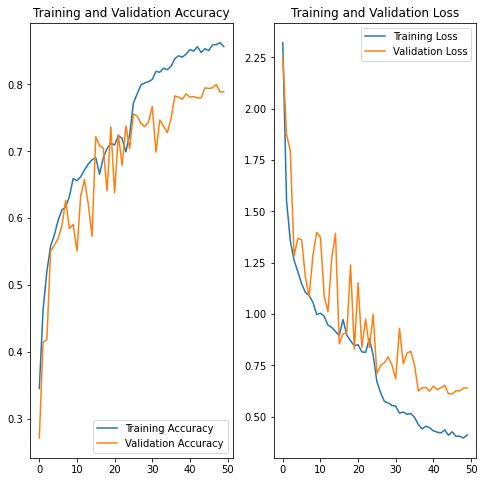

In [137]:
# 결과 시각화

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range=range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

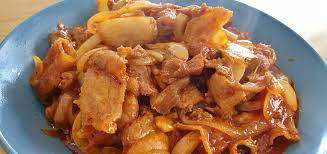

In [141]:
from PIL import Image

image = Image.open("/content/12345.jpg")
image

이 음식은 제육볶음 입니다.


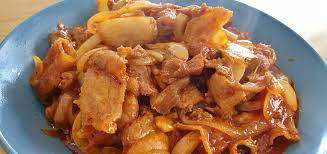

In [142]:
# 예측

from PIL import Image

image = Image.open("/content/12345.jpg")

test_path = '/content/12345.jpg'

img = keras.preprocessing.image.load_img(
    test_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 음식은 {} 입니다."
    .format(class_names[np.argmax(score)])
)
image

In [143]:
# HDF5 format으로 전체 model 저장하기

cur_dir = '/content/drive/MyDrive/ML_Dataset/'
save_dir_name = 'new_saved_models'
os.makedirs(save_dir_name, exist_ok=True)
hdf5_model_path = os.path.join(cur_dir, save_dir_name, 'my_new_model.h5')

In [144]:
# 저장

model.save(hdf5_model_path)